Student: **Mathis Embit**

# Derive the dual problem of LASSO and format it as a general Quadratic Problem

Let's compute the dual of the LASSO problem:

$$\begin{aligned} 
& \min_w \frac 12 \|Xw-y\|_2^2 + \lambda \|w\|_1\\
\end{aligned}$$

can be rewritten as

$$\begin{aligned} 
& \min_{w,z} & \frac{1}{2}\|z\|_2^2 + \lambda \|w\|_1 \\
& \text{s.t.} & z = Xw-y
\end{aligned}$$

The Lagrangian is $L(w,z,\nu) = \frac 12 \|z\|_2^2 + \lambda \|w\|_1 + \nu^T(Xw-y-z)$

Then we have

$\begin{aligned} 
g(\nu) = \inf_{w,z} L(w,z,\nu) 
&= \inf_{w,z} \left(\frac 12 \|z\|_2^2 + \lambda \|w\|_1 + \nu^T(Xw-y-z) \right) \\
&= \inf_{w,z} \left(\nu^TXw + \lambda \|w\|_1 - \nu^Tz + \frac 12 \|z\|_2^2 - \nu^Ty \right) \\
&= \inf_w \left( \nu^TXw + \lambda \|w\|_1 \right) + \inf_z \left( \frac 12 \|z\|_2^2 - \nu^Tz\right) - \nu^Ty\\
&= - \sup_w \left( \left(-\frac{1}{\lambda}X^T\nu\right)^Tw - \|w\|_1 \right) + \inf_z \left( \frac 12 z^Tz - \nu^Tz\right) - \nu^Ty\\
&= - f^*\left(-\frac{1}{\lambda}X^T\nu\right) - \frac{1}{2} \nu^T\nu - \nu^Ty\\
\end{aligned}$

where $f^*$ is the conjugate of $\|\cdot\|_1$ computed in HW2. Therefore

$$\begin{aligned}
g(\nu) & = \begin{cases}
- \frac{\|\nu\|_2^2}{2} - \nu^Ty & \text{ if } \|-\frac{1}{\lambda}X^T\nu\|_{\infty} \leq 1 \\
-\infty & \text{otherwise}
\end{cases} \\
& = \begin{cases}
- \frac{\|\nu\|_2^2}{2} - \nu^Ty & \text{ if } \|X^T\nu\|_{\infty} \leq \lambda \\
-\infty & \text{otherwise}
\end{cases}
\end{aligned}$$ 

Finally the LASSO dual is:

$$\begin{aligned} 
& \max_{\nu} & - \frac{\|\nu\|_2^2}{2} - \nu^Ty  \\
& \text{s.t.} & \|X^T\nu\|_{\infty} \leq \lambda
\end{aligned}$$

which is equvalent to

$$\begin{aligned} 
& \min_{\nu} & \frac{\|\nu\|_2^2}{2} + \nu^Ty  \\
& \text{s.t.} & \|X^T\nu\|_{\infty} \leq \lambda
\end{aligned}$$

We now need to format it as a general Quadratic Problem. We can alread write that $\frac{\|\nu\|_2^2}{2} + \nu^Ty = \nu^TQ\nu + p^T\nu$ where $Q = \frac{1}{2}I$ and $p = y$. We now need to identify $\|X^T\nu\|_{\infty} \leq \lambda$ to $A\nu \preceq b$.

$\begin{aligned} 
\|X^T\nu\|_{\infty} \leq \lambda & \iff \forall i \in \{1,\dots,n\}, -\lambda \leq \left( X^T\nu \right)_i \leq \lambda \\
& \iff \forall i \in \{1,\dots,n\}, \left( -X^T\nu \right)_i \leq \lambda \text{ and } \left( X^T\nu \right)_i \leq \lambda\\
& \iff \begin{pmatrix}X^T \\ -X^T \end{pmatrix}\nu \preceq \lambda \mathbb{1}_{2d}
\end{aligned}$

Hence, $A = \begin{pmatrix}X^T \\ -X^T \end{pmatrix}$ and $b = \lambda \mathbb{1}_{2d}$

**Conclusion**: the Quadratic Problem form of LASSO dual is
$$\boxed{
    \begin{aligned}
    & \min_{\nu \in \mathbb{R}^n} & \nu^TQ\nu + p^T\nu  \\
    & \text{s.t.} & A\nu \preceq b
\end{aligned}}$$

where

$$\boxed{
    \begin{aligned}
    & Q = \frac{1}{2}I \\
    & p = y \\
    & A = \begin{pmatrix}X^T \\ -X^T \end{pmatrix} \\
    & b = \lambda \mathbb{1}_{2d} \\
\end{aligned}}$$

# Implement the barrier method to solve QP

With the barrier method we want to minimize $f(\nu) = t(\nu^TQ\nu + p^T\nu) - \sum_{i=1}^{2d} \log \left( -(A\nu - b)_i \right) = t(\nu^TQ\nu + p^T\nu) - \sum_{i=1}^{2d} \log \left((b-A\nu)_i \right)$

First, let's write the gradient and the hessian of $f$:
$$\nabla f(\nu) = t((Q+Q^T)\nu + p) + \sum_{i=1}^{2d} \frac{1}{(b-A\nu)_i}A_i^T$$

$$Hf(\nu) = 2tQ + \sum_{i=1}^{2d} \frac{1}{(b-A\nu)_i^2}A_i^TA_i$$

In [1]:
# The code only needs 2 imports
import numpy as np # for computation
import matplotlib.pyplot as plt # to plot graphs

In [2]:
def objective(v, Q, p, A, b, t):
    """
    Calculate the objective function value for the given point 'v'.
    
    Inputs:
    - v: current point
    - Q, p, A, b: fixed parameters
    - t: parameter from barrier method

    Outputs:
    - f(v) = t(v^TQv + p^Tv) - sum(log(b-Av))
    """
    
    # Check feasibility
    if not (A@v <= b).all():
        raise Exception('v = {} is not feasible'.format(v))
    
    return t*(v.T@Q@v + p.T.dot(v)) - np.sum(np.log(b-A.dot(v)))

def gradient(v, Q, p, A, b, t):
    """
    Calculate the gradient of the objective function for the given point 'v'.

    Inputs:
    - v: current point
    - Q, p, A, b: fixed parameters
    - t: parameter from barrier method

    Outputs:
    - the gradient of f(v)
    """

    return t*((Q+Q.T)@v + p) + A.T@(1/(b-A.dot(v)))

def hessian(v, Q, p, A, b, t):
    """
    Calculate the Hessian matrix of the objective function for the given point 'v'.
    
    Inputs:
    - v: current point
    - Q, p, A, b: fixed parameters
    - t: parameter from barrier method

    Outputs:
    - the Hessian matrix of f(v)
    """

    denom = b-A.dot(v)
    res = 2*t*Q
    for i in range(A.shape[0]): # i from 1 to 2d
        res += 1/(denom[i])**2 * A[i,].reshape(-1,1).dot(A[i,].reshape(1,-1))
    
    return res

**`centering_step` function which implements the Newton method to solve the centering step**

In [3]:
def centering_step(Q,p,A,b,t,v0,eps,alpha=0.1,beta=0.75):
    """
    Perform a Newton's method on the gradient of the objective function.

    Inputs:
    - Q, p, A, b: fixed parameters
    - t: barrier method parameter
    - v0: initial point
    - eps: target precision
    - alpha: backtracking line search parameter (default=0.1)
    - beta: backtracking line search parameter (default=0.75)

    Outputs:
    - v: the optimized variable that minimizes the objective function
    - nb_steps: the number of iterations taken to reach the target precision
    """

    # Simplified notations
    f = lambda v: objective(v, Q, p, A, b, t)
    grad_f = lambda v: gradient(v, Q, p, A, b, t)
    hess_f = lambda v: hessian(v, Q, p, A, b, t)

    # Initialize variables
    v = v0
    nb_steps = 0
    step = float('inf')

    # Newton's method iterations
    while np.linalg.norm(step) > eps:
        # Compute Newton step
        step = np.linalg.inv(hess_f(v))@grad_f(v)

        # Backtracking line search
        rate=1
        while not(((A.dot(v-rate*step)-b)<=0).all()) or (f(v-rate*step) > f(v) - alpha*rate*grad_f(v).T.dot(step)):
            # Check constraint and sufficient decrease condition
            rate = rate*beta

        # Update variable using the step and rate
        v = v - rate*step
        nb_steps += 1
    
    return v, nb_steps

**`barr_method` function which implements the barrier method to solve QP**

In [4]:
def barr_method(Q,p,A,b,v0,eps,mu):
    """
    Perform the Barrier Method.

    Inputs:
    - Q, p, A, b: fixed parameters
    - v0: a feasible point
    - eps: a precision criterion
    - mu: reduction factor for the barrier method

    Outputs:
    - iterates: list containing the sequence of variable iterates
    - steps_index: list containing the cumulative number of iterations at each barrier method step
    """
    
    # Initialize variables
    iterates = [v0]
    t = 1
    m = A.shape[0]
    steps_index = [0]

    # Barrier Method iterations
    while m/t >= eps:
        v0, nb_steps = centering_step(Q,p,A,b,t,v0,eps)
        iterates.append(v0)
        t = mu*t
        steps_index.append(steps_index[-1]+nb_steps)
    
    return iterates, steps_index

# Test your function

It's now time to test the barrier method on some randomly generated data. Let's write a function that generates this test data.

In [5]:
def generate_data(n, d, beta_true, noise_std=1.0):
    """
    Generate synthetic data for testing Lasso barrier method.

    Inputs:
    - n: number of observations
    - d: number of features
    - beta_true: true coefficient values
    - noise_std: standard deviation of the noise (default=1.0)

    Outputs:
    - X: generated feature matrix
    - y: generated labels
    """
    np.random.seed(42) # set seed for reproducibility

    # Generate random feature matrix X
    X = np.random.randn(n, d)

    # Generate labels y with noise
    true_signal = X.dot(beta_true)
    noise = noise_std * np.random.randn(n)
    y = true_signal + noise

    return X, y

In [6]:
# Set parameters
n = 100 # number of samples
d = 10 # numer of features
true_w = np.random.randn(d)
noise_std = 1.0

# Generate synthetic data
X, y = generate_data(n, d, true_w, noise_std)

In [7]:
# Parameters of the LASSO problem
lmbd = 10
mus = [2, 15, 50, 100, 500]
Q = 0.5*np.eye(n)
p = y.reshape((y.shape[0],1))
A = np.vstack((X.T,-X.T))
b = lmbd*np.ones((2*d,1))
v0 = np.zeros((n,1))
eps = 0.001

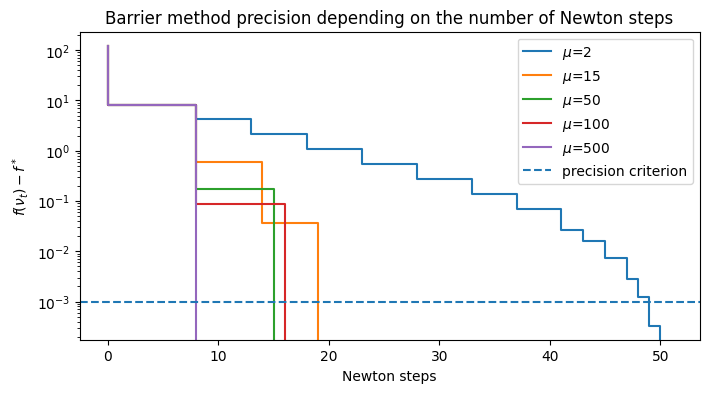

In [8]:
# Plot the results
plt.figure(figsize=(8,4)) 
for mu in mus:
    # Run Barrier Method to obtain variable iterates and cumulative steps
    iterates, steps_index = barr_method(Q,p,A,b,v0,eps,mu)

    # Best iterate based on the objective function value
    best = iterates[0]
    for v in iterates:
        if v.T@Q@v + p.T.dot(v) <= best.T@Q@best + p.T.dot(best):
            best = v
    
    # Calculate the difference in objective function value from the best iterate
    diff_iterates = [((v.T@Q@v + p.T.dot(v)) - (best.T@Q@best + p.T.dot(best)))[0,0] for v in iterates]
    plt.step(steps_index, diff_iterates, label=f'$\mu$={mu}')

# Plot the precision criterion as a horizontal line
plt.axhline(y=eps, label="precision criterion", linestyle='--')

# Plot formatting
plt.title("Barrier method precision depending on the number of Newton steps")
plt.semilogy() # semilog scale
plt.legend()
plt.xlabel('Newton steps')
plt.ylabel(fr'$f(\nu_t)-f^*$')
plt.show()

**What would be an appropriate choice for $\mu$ ?**

- We observe fewer barrier iterations when $\mu$ is large, but each barrier iterations contains a lot of Newton iterations.
- We observe more barrier iterations when $\mu$ is small, but each barrier iterations contains less Newton iterations.

To reach the wanted precision fast we can choose a large $\mu$, but if we want to balance barrier and Newton iterations, we can choose a $\mu$ around 20.